# Speech to Emotion Recognition (SER)

In [2]:
import librosa
from librosa import display
import os

In [6]:
#Loading audio from system and playing it in notebook
import IPython.display as ipd
from IPython.display import Audio

fpath=os.getcwd()
Audiofile=os.path.join(fpath,'./panic.wav')
ipd.Audio(Audiofile)

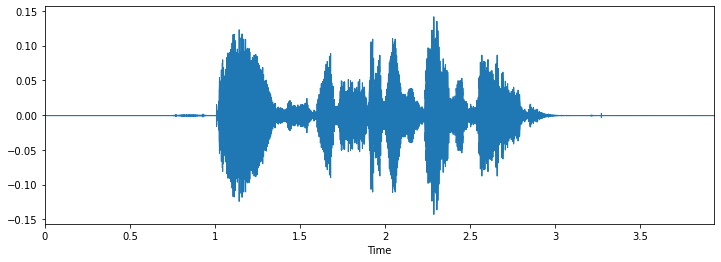

In [7]:
#Displaying wave-form of loaded audio file
import matplotlib.pyplot as plt

data, sr = librosa.load(Audiofile)
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sr)

### Cleaning the files of combined dataset

##### Now Cleaning Step is Performed where: DOWN SAMPLING OF AUDIO FILES IS DONE  AND PUT MASK OVER IT AND DIRECT INTO CLEAN FOLDER (MASK IS TO REMOVE UNNECESSARY EMPTY VOIVES AROUND THE MAIN AUDIO VOICE )

In [8]:
import os
import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.io import wavfile

def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [9]:
#All the cleaned Audio Files saved into Final_Cleaned_Dataset folder
import glob,pickle
for file in tqdm(glob.glob('..\\dataset_files\\RAVDESS\\**\\*.wav')):
    file_name = os.path.basename(file)
    signal , rate = librosa.load(file, sr=16000)
    mask = envelope(signal,rate, 0.0005)
    wavfile.write(filename= r'..\\Final_Cleaned_Dataset\\'+str(file_name), rate=rate,data=signal[mask])

100%|██████████████████████████████████████████████████████████████████████████████| 5252/5252 [18:07<00:00,  4.83it/s]


In [7]:
#Comparison
import matplotlib.pyplot as plt
original=os.path.join(fpath,'..//compare//original.wav')
cleaned=os.path.join(fpath,'..//compare//cleaned.wav')
dataOriginal, sr1 = librosa.load(original)
dataCleaned,sr2 = librosa.load(cleaned)


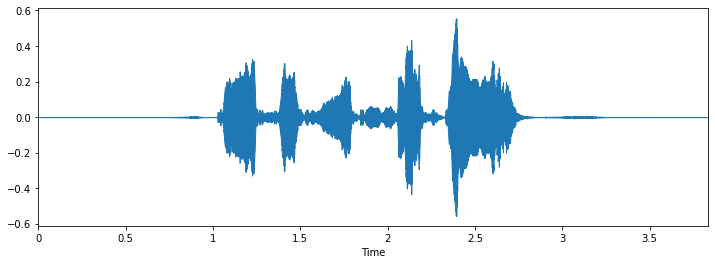

In [10]:
#Before Cleaning
plt.figure(figsize=(12, 4))
librosa.display.waveplot(dataOriginal, sr=sr1)
plt.savefig('..//Pictures//BeforeCleanin.png') 

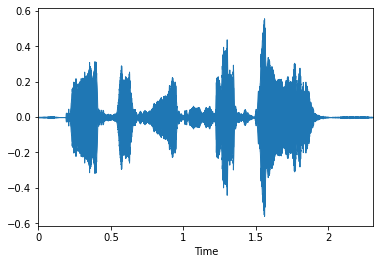

In [11]:
#After Cleaning
librosa.display.waveplot(dataCleaned, sr=sr2)
plt.savefig('..//Pictures//AfterCleaning.png') 

In [12]:
import time
import os
import numpy as np

path="..\\Final_Cleaned_Dataset\\"

lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:

        X, sr = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0) 

        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
    
      except ValueError:
        continue

print("Time taken : %s minutes " % ((time.time() - start_time)/60))

Time taken : 1.40918079217275 minutes 


In [13]:
#This zip() function makes list of all first elements and store in mfcc list
#also it stores all the second elements in emotions list

mfcc, emotions = zip(*lst)

In [14]:
print(emotions[1800])

2


In [15]:
audio_df = pd.DataFrame(emotions)
audio_df = audio_df.replace({0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'})

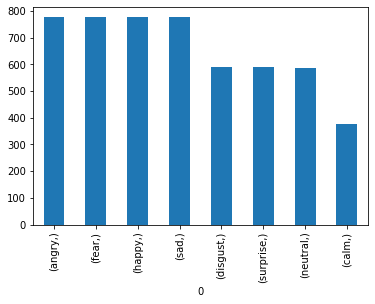

In [18]:
audio_df.value_counts().plot(kind='bar')
plt.savefig('..//Pictures//DistributionBar.png') 

In [19]:
mfcc = np.asarray(mfcc)
emotions = np.asarray(emotions)

In [20]:
from sklearn.model_selection import train_test_split

mfcc_train, mfcc_test, emotions_train, emotions_test = train_test_split(mfcc,emotions, test_size=0.20, random_state=42)

In [21]:
import numpy as np

mfcc_train = np.expand_dims(mfcc_train, axis=2)
mfcc_test = np.expand_dims(mfcc_test, axis=2)

## Defining Model for training

##### Used Keras library from tensorflow framework to define a sequencial CNN Model and added layers according to operation be performed on input mfcc features

In [22]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [28]:
model = Sequential()

model.add(Conv1D(64, 5,padding='same',input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 40, 64)            384       
_________________________________________________________________
activation_4 (Activation)    (None, 40, 64)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10, 128)           41088     
_________________________________________________________________
activation_5 (Activation)    (None, 10, 128)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 128)          

In [30]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [31]:
cnnhistory=model.fit(mfcc_train, emotions_train, batch_size=16, epochs=200, validation_data=(mfcc_test, emotions_test))

Epoch 1/200
263/263 [==============================] - 2s 5ms/step - loss: 4.3078 - accuracy: 0.1561 - val_loss: 1.6904 - val_accuracy: 0.3720
Epoch 2/200
263/263 [==============================] - 1s 4ms/step - loss: 2.3005 - accuracy: 0.2846 - val_loss: 1.3724 - val_accuracy: 0.5538
Epoch 3/200
263/263 [==============================] - 1s 4ms/step - loss: 1.6948 - accuracy: 0.4178 - val_loss: 1.2759 - val_accuracy: 0.6032
Epoch 4/200
263/263 [==============================] - 1s 4ms/step - loss: 1.4051 - accuracy: 0.5204 - val_loss: 1.1733 - val_accuracy: 0.6080
Epoch 5/200
263/263 [==============================] - 1s 4ms/step - loss: 1.3126 - accuracy: 0.5417 - val_loss: 1.1266 - val_accuracy: 0.6327
Epoch 6/200
263/263 [==============================] - 1s 4ms/step - loss: 1.1941 - accuracy: 0.5959 - val_loss: 1.0800 - val_accuracy: 0.6556
Epoch 7/200
263/263 [==============================] - 1s 4ms/step - loss: 1.1383 - accuracy: 0.6046 - val_loss: 1.0233 - val_accuracy: 0.6755

Epoch 58/200
263/263 [==============================] - 1s 5ms/step - loss: 0.4483 - accuracy: 0.8399 - val_loss: 0.5216 - val_accuracy: 0.8126
Epoch 59/200
263/263 [==============================] - 1s 5ms/step - loss: 0.4514 - accuracy: 0.8406 - val_loss: 0.5148 - val_accuracy: 0.8116
Epoch 60/200
263/263 [==============================] - 1s 5ms/step - loss: 0.4909 - accuracy: 0.8258 - val_loss: 0.4996 - val_accuracy: 0.8268
Epoch 61/200
263/263 [==============================] - 1s 5ms/step - loss: 0.4563 - accuracy: 0.8301 - val_loss: 0.5178 - val_accuracy: 0.8183
Epoch 62/200
263/263 [==============================] - 1s 5ms/step - loss: 0.4576 - accuracy: 0.8411 - val_loss: 0.4969 - val_accuracy: 0.8297
Epoch 63/200
263/263 [==============================] - 1s 5ms/step - loss: 0.4194 - accuracy: 0.8529 - val_loss: 0.5043 - val_accuracy: 0.8202
Epoch 64/200
263/263 [==============================] - 1s 5ms/step - loss: 0.4275 - accuracy: 0.8434 - val_loss: 0.4969 - val_accuracy:

Epoch 115/200
263/263 [==============================] - 1s 5ms/step - loss: 0.3190 - accuracy: 0.8863 - val_loss: 0.4337 - val_accuracy: 0.8382
Epoch 116/200
263/263 [==============================] - 1s 5ms/step - loss: 0.3231 - accuracy: 0.8836 - val_loss: 0.4389 - val_accuracy: 0.8402
Epoch 117/200
263/263 [==============================] - 1s 5ms/step - loss: 0.3089 - accuracy: 0.8888 - val_loss: 0.4261 - val_accuracy: 0.8506
Epoch 118/200
263/263 [==============================] - 1s 5ms/step - loss: 0.3020 - accuracy: 0.9011 - val_loss: 0.4385 - val_accuracy: 0.8535
Epoch 119/200
263/263 [==============================] - 1s 5ms/step - loss: 0.3137 - accuracy: 0.8837 - val_loss: 0.4302 - val_accuracy: 0.8430
Epoch 120/200
263/263 [==============================] - 1s 5ms/step - loss: 0.2822 - accuracy: 0.8990 - val_loss: 0.4247 - val_accuracy: 0.8544
Epoch 121/200
263/263 [==============================] - 1s 5ms/step - loss: 0.2973 - accuracy: 0.8901 - val_loss: 0.4330 - val_ac

### Displaying Model accuracy and plots

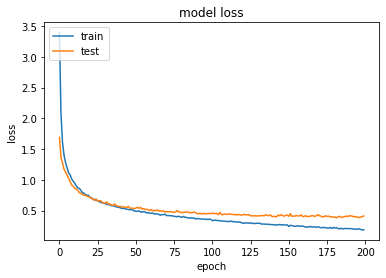

In [32]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('..//Pictures//Loss_Model.png') 
plt.show()

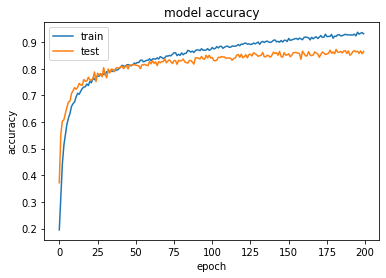

In [33]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('..//Pictures//Accuracy_Model.png') 
plt.show()

In [34]:
loss,acc = model.evaluate(mfcc_test, emotions_test)
print("The accuracy of trained model is :{:5.2f}%".format(100*acc))

33/33 [==============================] - 0s 2ms/step - loss: 0.4128 - accuracy: 0.8649
The accuracy of trained model is :86.49%


In [36]:
predictions = model.predict_classes(mfcc_test)

In [37]:
print(predictions)

[6 1 0 ... 7 2 4]


## Confusion Matrix

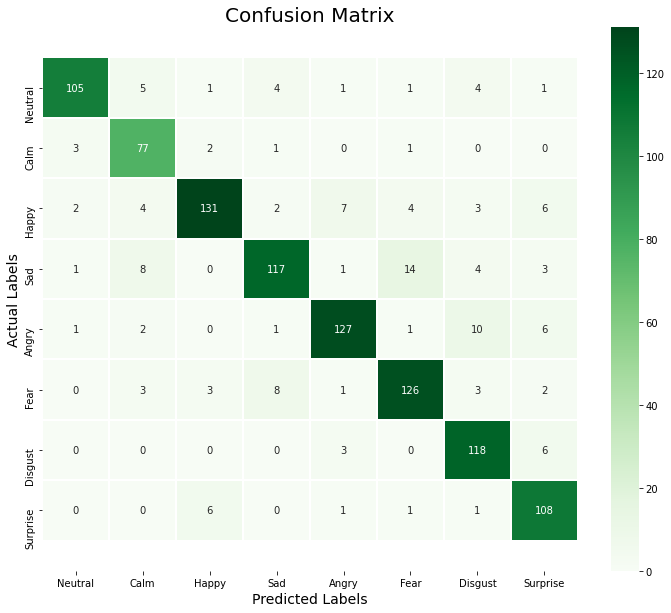

In [38]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

new_Ytest = emotions_test.astype(int)
matrix = confusion_matrix(new_Ytest, predictions)
# print (matrix)
# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

plt.figure(figsize = (12, 10))
matrix = pd.DataFrame(matrix , index = ["Neutral","Calm","Happy","Sad","Angry","Fear","Disgust","Surprise"] , columns = ["Neutral","Calm","Happy","Sad","Angry","Fear","Disgust","Surprise"])
ax = sns.heatmap(matrix, linecolor='white', cmap='Greens', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('..//Pictures//Confusion_matrix.png') 
plt.show()

### Printing Precision, Recall, F1-Score and Support values of model

In [40]:
from sklearn.metrics import classification_report

report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.86      0.90       122
           1       0.78      0.92      0.84        84
           2       0.92      0.82      0.87       159
           3       0.88      0.79      0.83       148
           4       0.90      0.86      0.88       148
           5       0.85      0.86      0.86       146
           6       0.83      0.93      0.87       127
           7       0.82      0.92      0.87       117

    accuracy                           0.86      1051
   macro avg       0.86      0.87      0.86      1051
weighted avg       0.87      0.86      0.86      1051



In [38]:
#Saving our trained model as CNN_Model.h5

model.save('CNN_Model.h5')
print("MODEL SAVED")

MODEL SAVED


In [39]:
#Loading back the saved model

our_model=keras.models.load_model('CNN_Model.h5')


In [40]:
loss, acc = our_model.evaluate(mfcc_test, emotions_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

33/33 [==============================] - 0s 3ms/step - loss: 0.4206 - accuracy: 0.8620
Restored model, accuracy: 86.20%


## Using model for live prediction

In [1]:
import keras
import numpy as np
import librosa
import soundfile as sf

In [2]:
class modelPredictions:

    def __init__(self, path, file):
        self.path = path
        self.file = file

    def load_model(self):
        self.loaded_model = keras.models.load_model(self.path)
        #return self.loaded_model.summary()

    def predictEmotion(self):
        data, sr = librosa.load(self.file)
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        x = np.expand_dims(mfccs, axis=1)
        x = np.expand_dims(x, axis=0)
        predictedEmotion = self.loaded_model.predict_classes(x)
        print("The predicted emotion is : ", " ", self.convertclasstoemotion(predictedEmotion))

    @staticmethod
    def convertclasstoemotion(p):
        #predictions(int) to understandable emotion labeling
        label_conversion = {'0': 'neutral','1': 'calm','2': 'happy','3': 'sad','4': 'angry','5': 'fearful','6': 'disgust','7': 'surprised'}

        for key, value in label_conversion.items():
            if int(key) == p:
                label = value
        return label

In [ ]:
#Created the object p of class modelPredictions
p1 = modelPredictions(path='CNN_Model.h5',file='Recording.wav')
p1.load_model()
#called predictEmotion function to predict emotion type of input file
p1.predictEmotion()

In [ ]:
#Created the object p of class modelPredictions
p2 = modelPredictions(path='CNN_Model.h5',file='Recording-Surprise.wav')
p2.load_model()
#called predictEmotion function to predict emotion type of input file
p2.predictEmotion()

In [ ]:
#Created the object p of class modelPredictions
p3 = modelPredictions(path='CNN_Model.h5',file='Recording-Happy .wav')
p3.load_model()
#called predictEmotion function to predict emotion type of input file
p3.predictEmotion()